In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openparticle.hamiltonians.yukawa_hamiltonians import yukawa_hamiltonian
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))

from colors import *
import pickle

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-24 11:31:30,266	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
with open('full_yukawa_data/full_yukawa_3_2_6.pickle', 'rb') as handle:
    (LCU_DATA, LCU_PIECEWISE_DATA, LOBE_DATA, operator_norms, bosonic_cutoff, resolution_range) = pickle.load(handle)

numbers_of_modes = []
for resolution in resolution_range:
    operator = yukawa_hamiltonian(res=resolution, g=1, mf=1, mb=1)
    total_number_of_modes = 0
    if operator.max_fermionic_mode is not None:
        total_number_of_modes += operator.max_fermionic_mode + 1
    if operator.max_bosonic_mode is not None:
        total_number_of_modes += operator.max_bosonic_mode + 1
    numbers_of_modes.append(total_number_of_modes)

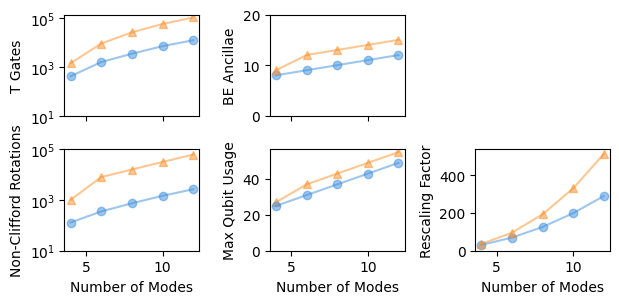

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16 / 2.54, 8 / 2.54))

axes[0][0].plot(
    numbers_of_modes,
    [(4 * LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_modes))],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[0][0].plot(
    numbers_of_modes,
    [(4 * LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_modes))],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[0][0].plot(
#     numbers_of_modes,
#     [(4 * LCU_PIECEWISE_DATA[i][0].number_of_elbows) + LCU_PIECEWISE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_modes))],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticklabels([])
axes[0][0].set_yscale("log")
axes[0][0].set_yticks([1e1, 1e3, 1e5])

axes[1][0].plot(
    numbers_of_modes,
    [
        LOBE_DATA[i][0].number_of_nonclifford_rotations
        for i in range(len(numbers_of_modes))
    ],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[1][0].plot(
    numbers_of_modes,
    [
        LCU_DATA[i][0].number_of_nonclifford_rotations
        for i in range(len(numbers_of_modes))
    ],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[1][0].plot(
#     numbers_of_modes,
#     [
#         LCU_PIECEWISE_DATA[i][0].number_of_nonclifford_rotations
#         for i in range(len(numbers_of_modes))
#     ],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Number of Modes")
axes[1][0].set_yscale("log")
axes[1][0].set_yticks([1e1, 1e3, 1e5])


axes[0][1].plot(
    numbers_of_modes,
    [LOBE_DATA[i][2] for i in range(len(numbers_of_modes))],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[0][1].plot(
    numbers_of_modes,
    [LCU_DATA[i][2] for i in range(len(numbers_of_modes))],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[0][1].plot(
#     numbers_of_modes,
#     [LCU_PIECEWISE_DATA[i][2] for i in range(len(numbers_of_modes))],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 10, 20])

axes[1][1].plot(
    numbers_of_modes,
    [
        LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + LCU_DATA[i][3] + 1
        for i in range(len(numbers_of_modes))
    ],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
axes[1][1].plot(
    numbers_of_modes,
    [
        LOBE_DATA[i][0].ancillae_highwater()
        + LOBE_DATA[i][2]
        + LOBE_DATA[i][3]
        + 1
        for i in range(len(numbers_of_modes))
    ],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
# axes[1][1].plot(
#     numbers_of_modes,
#     [
#         LCU_PIECEWISE_DATA[i][0].ancillae_highwater()
#         + LCU_PIECEWISE_DATA[i][2]
#         + LCU_PIECEWISE_DATA[i][3]
#         + 1
#         for i in range(len(numbers_of_modes))
#     ],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Number of Modes")
axes[1][1].set_yticks([0, 20, 40])

axes[1][2].plot(
    numbers_of_modes,
    [LOBE_DATA[i][1] for i in range(len(numbers_of_modes))],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[1][2].plot(
    numbers_of_modes,
    [LCU_DATA[i][1] for i in range(len(numbers_of_modes))],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[1][2].plot(
#     numbers_of_modes,
#     [LCU_PIECEWISE_DATA[i][1] for i in range(len(numbers_of_modes))],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
# axes[1][2].plot(
#     numbers_of_modes,
#     [operator_norms[i] for i in range(len(numbers_of_modes))],
#     color="black",
#     marker="x",
#     ls="--",
#     alpha=0.5,
# )
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Number of Modes")
axes[1][2].set_yticks([0, 200, 400])

fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[2][0].legend(
#     loc="upper center",
#     bbox_to_anchor=(1.5, 0.75),
#     fancybox=True,
#     shadow=True,
#     ncol=1,
# )
# plt.savefig(f"../../../manuscript/figures/full-yukawa-resolution-{bosonic_cutoff}.pdf", dpi=300)

